In [271]:
# some ideas just for curiosity:
# - could train an RL model to predict what dominoes are in other agents hands based on what has been played, their line, and what is available...
# - for hand-crafted networks, I wonder if graph theory methods can speed up the line-value estimation methods...

In [2]:
%reload_ext autoreload
%autoreload 2

import time
from copy import copy
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from dominoes import leagueManager as lm
from dominoes import gameplay as dg
from dominoes import agents as da
from dominoes import functions as df
from dominoes import fileManagement as fm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [179]:
# Specific Updates to Value Agents --
# - I don't think I need to estimate pre/post states every play. This will save so much computation time, and may even be easier for the agents to learn. 
# - !! It seems like I do need to estimate pre/post states every play. However, I think there's an alternative solution:
#         - instead of measuring TD error between the pre & post state, I can measure TD error between the pre-state and the next agent turn's pre-state.
#         - this way, the agent will be able to build longer-term connections, but will still only estimate value once per round of turns...

# Blog Post Planning: 
# 1. Creating a system that plays dominoes
# 2. Hand-crafted agents that play with specific rules
# 3. Finding a way to represent the game-state in a way that can be fed to a neural network
#    3.1 -- Simple networks can't learn how to do addition and biased subtraction...?
# 4. Adding information to the game-state about possible line sequences for the network to use more information in deciding how to play
#    4.1 -- comparing performance of the lineValueNetwork where it is trained against bad agents or good agents
#    4.2 -- comparing performance of the lineValueNetwork when it uses pre-poststate updates on every turn, only it's own turn, or only on it's own turn but before/after all other agents have had their turn...
# 5. Building a neural network that can outperform the line value networks without hand-crafted information (e.g. with transformers)

In [4]:
highestDominoe = 9
numPlayers = 4
league = lm.leagueManager(highestDominoe, numPlayers, shuffleAgents=True)

In [5]:
league.addAgentType(da.bestLineAgent)
league.addAgentType(da.doubleAgent)
league.addAgentType(da.greedyAgent)
league.addAgentType(da.dominoeAgent)

In [6]:
game, leagueIndex = league.createGame()

In [7]:
game.initializeHand()

In [8]:
game.playGame(rounds=3)
game.printResults()
league.updateElo(leagueIndex, game.currentScore) # update ELO

Scores for each round:
[[ 0  0 47  1]
 [16  3 14  0]
 [16  0 39  6]]

Final score:
[ 32   3 100   7]

The winner is agent: 1 with a score of 3, they went out in 2/3 rounds.


In [ ]:
highestDominoe = 9
numPlayers = 4

league = lm.leagueManager(highestDominoe, numPlayers, shuffleAgents=True)

numEach = 4
league.addAgentType(da.bestLineAgent, num2add=numEach)
league.addAgentType(da.doubleAgent, num2add=numEach)
league.addAgentType(da.greedyAgent, num2add=numEach)
league.addAgentType(da.dominoeAgent, num2add=numEach)
league.addAgentType(da.stupidAgent, num2add=numEach)

numGames = 10000
trackElo = np.zeros((numGames, league.numAgents))
for gameIdx in tqdm(range(numGames)):
    game, leagueIndex = league.createGame()
    game.playGame()
    league.updateElo(leagueIndex, game.currentScore) # update ELO
    trackElo[gameIdx] = copy(league.elo)

print([int(elo) for elo in league.elo])

 40%|██████████████████████████████▉                                              | 4024/10000 [09:53<11:37,  8.56it/s]

In [ ]:
avgEloPerAgentType = np.mean(trackElo.T.reshape(5,numEach,numGames),axis=1)
agentTypeNames = [agent.agentName for agent in league.agents[::numEach]]

fig = plt.figure()
for name, elo in zip(agentTypeNames, avgEloPerAgentType):
    plt.plot(range(numGames), elo, label=name, linewidth=2)
plt.xlabel('Number of games')
plt.ylabel('Average ELO')
plt.ylim(800, 2000)
plt.legend(fontsize=10, loc='lower left')
plt.show()

In [11]:
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None, labelLines=True) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None, labelLines=True) #player=game.linePlayer, playNumber=game.linePlayNumber)

player 0:  [' 0|2 ', ' 2|8 ', ' 8|9 ', ' 9|6 ', ' 6|6 ', ' 6|3 ']
player 1:  [' 0|8 ', ' 8|8 ', ' 8|7 ', ' 7|7 ', ' 7|9 ', ' 9|5 ', ' 5|7 ', ' 7|6 ']
player 2:  [' 0|1 ', ' 1|3 ', ' 3|3 ', ' 3|7 ', ' 7|0 ', ' 0|6 ', ' 6|4 ']
player 3:  [' 0|5 ', ' 5|5 ', ' 5|2 ', ' 2|2 ', ' 2|1 ', ' 1|4 ', ' 4|5 ', ' 5|3 ', ' 3|2 ']
dummy:  [' 0|4 ', ' 4|3 ', ' 3|8 ', ' 8|5 ', ' 5|6 ', ' 6|2 ', ' 2|4 ', ' 4|9 ', ' 9|3 ', ' 3|0 ', ' 0|9 ', ' 9|9 ', ' 9|1 ', ' 1|1 ', ' 1|8 ']


In [294]:
game.dummyPlayNumber

[5, 11, 14, 18, 22, 23, 25, 27, 28, 32, 33, 34, 39, 43]

In [423]:
# bestLineAgeng against randomAgent on 9s
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.bestLineAgent, None, None, None), shuffleAgents=False, defaultAgent=da.dominoeAgent)

numRounds = 1000
game.playGame(rounds=numRounds, withUpdates=True)
game.printResults()

print(np.round(game.currentScore / numRounds,2))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.65it/s]

Scores for each round:
[[26 10  4  9]
 [ 0  6 35 24]
 [ 0  9 14 48]
 ...
 [ 5  7  0  6]
 [ 9  9 10  8]
 [11  8  0 30]]

Final score:
[ 6307 19615 18766 18481]

The winner is agent: 0 with a score of 6307, they went out in 392/1000 rounds.
[ 6.31 19.61 18.77 18.48]


In [424]:
# bestLineAgeng against randomAgent on 12s
highestDominoe = 12
game = dg.dominoeGame(highestDominoe, agents=(da.bestLineAgent, None, None, None), shuffleAgents=False, defaultAgent=da.dominoeAgent)

numRounds = 1000
game.playGame(rounds=numRounds, withUpdates=True)
game.printResults()

print(np.round(game.currentScore / numRounds,2))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [25:22<00:00,  1.52s/it]

Scores for each round:
[[ 0 23 62 29]
 [ 0 60 66 48]
 [20  0 43 69]
 ...
 [ 3 28 45  0]
 [17 57 17 47]
 [25  0 13  0]]

Final score:
[ 7432 26936 28108 26600]

The winner is agent: 0 with a score of 7432, they went out in 481/1000 rounds.
[ 7.43 26.94 28.11 26.6 ]


In [420]:
# bestLineAgeng against doubleAgents on 9s
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.bestLineAgent, None, None, None), shuffleAgents=False, defaultAgent=da.doubleAgent)

numRounds = 1000
game.playGame(rounds=numRounds, withUpdates=True)
game.printResults()

print(np.round(game.currentScore / numRounds,2))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.93it/s]

Scores for each round:
[[19  0  5  9]
 [21  0  2 14]
 [13 40  0  3]
 ...
 [13 12 12  0]
 [ 0 27 13  5]
 [ 0 46 22 25]]

Final score:
[ 9498 10723 10862 10359]

The winner is agent: 0 with a score of 9498, they went out in 262/1000 rounds.
[ 9.5  10.72 10.86 10.36]


In [419]:
# bestLineAgent against doubleAgents on 12s
highestDominoe = 12
game = dg.dominoeGame(highestDominoe, agents=(da.bestLineAgent, None, None, None), shuffleAgents=False, defaultAgent=da.doubleAgent)

numRounds = 1000
game.playGame(rounds=numRounds, withUpdates=True)
game.printResults()

print(np.round(game.currentScore / numRounds,2))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [26:15<00:00,  1.58s/it]

Scores for each round:
[[19 26  1 16]
 [ 0  6  4  2]
 [ 0 16  4 24]
 ...
 [ 0 35 26 15]
 [23  5 13  0]
 [18 13 13 14]]

Final score:
[12481 13083 12075 11709]

The winner is agent: 3 with a score of 11709, they went out in 258/1000 rounds.
[12.48 13.08 12.08 11.71]


In [425]:
# lineValueAgent against doubleAgents on 9s
prmPath = r'experimentSet_000/savedNetworks/lineValueAgentParameters_230817_1.npy'

highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.lineValueAgent, None, None, None), shuffleAgents=False, defaultAgent=da.doubleAgent)
game.getAgent(0).loadAgentParameters(fm.codePath() / prmPath)
                                     
numRounds = 1000
game.playGame(rounds=numRounds, withUpdates=True)
game.printResults()

print(np.round(game.currentScore / numRounds,2))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:12<00:00,  1.36it/s]

Scores for each round:
[[ 0 36 25  9]
 [ 0  1  4 20]
 [ 9  0 22 12]
 ...
 [ 0 16 17  6]
 [38  5 25  0]
 [ 0 54 32 39]]

Final score:
[ 6532 12606 12347 11406]

The winner is agent: 0 with a score of 6532, they went out in 434/1000 rounds.
[ 6.53 12.61 12.35 11.41]


In [426]:
game.score

array([[ 0, 36, 25,  9],
       [ 0,  1,  4, 20],
       [ 9,  0, 22, 12],
       ...,
       [ 0, 16, 17,  6],
       [38,  5, 25,  0],
       [ 0, 54, 32, 39]])

In [34]:
# This block presents the results of the experiment from experimentSet000-0

numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, numPlayers=numPlayers, agents=(da.lineValueAgent, da.bestLineAgent, da.bestLineAgent, da.bestLineAgent), device=device)

fileNames = [
    r'experimentSet_000/savedNetworks/lineValueAgentParameters_230817_0.npy',
    r'experimentSet_000/savedNetworks/lineValueAgentParameters_230817_1.npy',
    r'savedNetworks/lineValueAgentParameters_230816_0.npy',
    r'savednetworks/lineValueAgentParameters_230816_1.npy'
]

performanceGames = 10
performanceRounds = 50

testWinner = np.zeros((len(fileNames),numPlayers))
testScoreTally = np.zeros((len(fileNames),numPlayers))

for idx, file in enumerate(fileNames):
    game.getAgent(0).loadAgentParameters(fm.codePath() / file)
    game.getAgent(0).setLearning(False)
    
    # measure performance
    for _ in tqdm(range(performanceGames)):
        game.playGame(rounds=performanceRounds)
        testWinner[idx, game.currentWinner] += 1 
        testScoreTally[idx] += game.currentScore

# report results of training lineValueAgent against greedyAgents
print(f"Games won: ")
print(testWinner)
print(f"Expected score per hand: ")
print(testScoreTally / performanceGames / performanceRounds)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [10:03<00:00, 60.39s/it]

Games won: 
[[6. 0. 2. 2.]
 [7. 1. 1. 1.]
 [6. 1. 1. 2.]
 [6. 1. 2. 1.]]
Expected score per hand: 
[[ 9.886 12.252 11.222 11.276]
 [ 9.53  12.078 12.04  11.002]
 [10.03  12.45  12.438 11.604]
 [10.298 11.572 11.378 10.982]]


In [315]:
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__)

x = [5,2,1,10]

# %timeit argsort(x)
# %timeit np.argsort(x)

print(argsort(x))
print(np.argsort(x))

print(sorted(x, key=range(len(x)).__getitem__))

[2, 1, 0, 3]
[2 1 0 3]


IndexError: range object index out of range

In [321]:
leagueIndex = [1,3,5,2]
gameResults = [0,18,1,19]
idxScoreOrder = df.argsort(gameResults) # scores in order
sortedLeagueIndex = [leagueIndex[i] for i in idxScoreOrder]
sortedGameResults = [gameResults[i] for i in idxScoreOrder]

print(sortedLeagueIndex)
print(sortedGameResults)

[1, 5, 3, 2]
[0, 1, 18, 19]


In [325]:
leagueIndex = [1,3,5,2]
gameResults = [0,18,1,19]

def zipMethod(list1, list2):
    # Combine the two lists into pairs
    combined_pairs = list(zip(list1, list2))
    
    # Sort the pairs based on values in list1
    sorted_pairs = sorted(combined_pairs, key=lambda x: x[0])
    
    # Unpack the sorted pairs into separate lists
    sorted_list1, sorted_list2 = zip(*sorted_pairs)
    
    return list(sorted_list1), list(sorted_list2)

def listCompMethod(list1, list2):
    idxOrder = df.argsort(list1)
    return [list1[i] for i in idxOrder], [list2[i] for i in idxOrder]

%timeit l1, l2 = zipMethod(gameResults, leagueIndex)
%timeit m1, m2 = listCompMethod(gameResults, leagueIndex)

print(l1, l2)

print(m1, m2)

861 ns ± 5.96 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
882 ns ± 12.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
[0, 1, 18, 19] [1, 5, 3, 2]
[0, 1, 18, 19] [1, 5, 3, 2]


In [ ]:
# System for vieweing agent value function: 
# game = ()
# game.initializeHand()
# game.showTurn() # where showTurn acts like doTurn, but tells the agent to reveal it's choices and value functions

In [35]:
numPlayers = 4
highestDominoe = 9
dominoes = df.listDominoes(highestDominoe)
numDominoes = len(dominoes)
lvAgent = da.lineValueAgent(numPlayers, highestDominoe, dominoes, numDominoes, 0)
lvAgent.loadAgentParameters(fm.codePath() / 'experimentSet_000' / 'savedNetworks' / 'lineValueAgentParameters_230817_1.npy')

In [44]:
print(lvAgent.finalScoreNetwork)
# Goals: 
# 1. look at Linear layer of cnnLayer, find out how similar it is across dominoes
# 2. Same for first linear layer of ffLayer
# 3. Initialize the game many times, look at correlation between average lineValueFeatures and final score output
# -
# 1. Find out how to optimize the input to the network for the best output (e.g. hand value 0)
#    - will probably have to do this under certain constraints, e.g. with the constraint that dominoes in each hand remains high
#    - I wonder if I can do it for just the lineRepresentation input? 

# I think the way I do it is this: 
# Take a sample input, run it through the network to get the value. 
# Run backward() on the output of the network
# Update the input
# Do again


lineRepresentationNetwork(
  (cnn_c1): Conv1d(6, 10, kernel_size=(1,), stride=(1,))
  (cnn_f1): Linear(in_features=550, out_features=1000, bias=True)
  (cnn_ln): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
  (cnnLayer): Sequential(
    (0): Conv1d(6, 10, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Flatten(start_dim=0, end_dim=-1)
    (3): Linear(in_features=550, out_features=1000, bias=True)
    (4): ReLU()
    (5): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
  )
  (fc1): Linear(in_features=1177, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=1, bias=True)
  (ffLayer): Sequential(
    (0): Linear(in_features=1177, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=500, bias=True)
   

In [42]:
# expInLineValue, expOffLineValue, expLossValue, expDominoeValue, expInLineDominoes, expOffLineDominoes
lvAgent.finalScoreNetwork.cnn_c1.weight.view(10,6)

tensor([[ 0.1833,  0.1032, -0.0776,  0.0994,  0.0312, -0.1081],
        [ 0.1618,  0.0069,  0.1001, -0.0982, -0.2243,  0.1485],
        [-0.0262,  0.0719,  0.1326, -0.0475, -0.1863,  0.1184],
        [-0.2506,  0.0444,  0.2222, -0.2975, -0.1003, -0.3702],
        [ 0.1716, -0.2949,  0.0487,  0.2492, -0.2473, -0.0033],
        [-0.0689,  0.0464,  1.0099, -1.0141,  0.0679,  0.1642],
        [-0.1283, -0.0643, -0.1278, -0.2202, -0.2645, -0.1587],
        [-0.0977, -0.0191, -0.1356,  0.1025, -0.2359, -0.2980],
        [-0.3415, -0.0836,  0.5119, -0.0513,  0.1220, -0.2324],
        [-0.2302, -0.2922, -0.1383,  0.2512,  0.1618,  0.1330]],
       grad_fn=<ViewBackward0>)

In [163]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, numPlayers=numPlayers, agents=(da.lineValueAgent, da.bestLineAgent, da.bestLineAgent, da.bestLineAgent), device=device)
game.getAgent(0).loadAgentParameters(fm.codePath() / 'experimentSet_000' / 'savedNetworks' / 'lineValueAgentParameters_230817_1.npy')
game.getAgent(0).setLearning(False)
game.initializeHand()

In [168]:
print(f"Current agent: {game.agents[game.nextPlayer].agentName}")
if game.originalAgentIndex[game.nextPlayer]==0:
    print(f"Loading agent with game state...")
    currentPlayer = copy(game.nextPlayer)
    game.presentGameState(currentPlayer, postState=False)
    lvInput = game.getAgent(0).valueNetworkInput[0].clone()
    gsInput = game.getAgent(0).valueNetworkInput[1].clone()
    lvInput.requires_grad=True
    gsInput.requires_grad=True
    lvInput.retain_grad()
    gsInput.retain_grad()
    finalScoreOutput = game.getAgent(0).finalScoreNetwork(game.getAgent(0).valueNetworkInput)
else:
    print(f"Doing turn...")
    game.doTurn()

Current agent: lineValueAgent
Loading agent with game state...


In [169]:
print(lvInput.shape, gsInput.shape)
print(lvInput.requires_grad, gsInput.requires_grad)
print(finalScoreOutput)

torch.Size([6, 55]) torch.Size([177])
True True
tensor([7.9914], device='cuda:0', grad_fn=<AddBackward0>)


In [170]:
print(np.round(game.getAgent(0).valueNetworkInput[0].T[game.getAgent(0).myHand].clone().detach().cpu().numpy(),1))

[[67.1  1.3  3.   2.  10.   4. ]
 [67.1  1.3 10.   7.  10.   4. ]
 [67.1  1.3 13.  10.6 10.   4. ]
 [67.2  1.3  8.   5.5 10.   4. ]
 [67.1  1.3  8.   5.7 10.   4. ]
 [59.8  1.8  2.   0.  10.   4. ]
 [67.1  1.3 16.   6.9 10.   4. ]
 [53.6  2.7 10.   0.   8.9  5.1]
 [67.1  1.3 11.   8.5 10.   4. ]
 [64.6  1.5  6.   0.1 10.   4. ]
 [67.1  1.3 16.  12.4 10.   4. ]
 [67.1  1.3 12.   5.2 10.   4. ]
 [67.2  1.3  6.   3.4 10.   4. ]
 [64.4  1.5  4.   0.  10.   4. ]]


In [ ]:
# expInLineValue, expOffLineValue, expLossValue, expDominoeValue, expInLineDominoes, expOffLineDominoes

In [178]:
lvInput.shape

torch.Size([6, 55])

In [171]:
eps = 1e-1
numEpochs = 3000
for epoch in tqdm(range(numEpochs)):
    finalScoreOutput = game.getAgent(0).finalScoreNetwork((lvInput, gsInput))
    finalScoreOutput.backward()
    lvInput = (lvInput - eps*lvInput.grad).clone()
    lvInput.retain_grad()
    gsInput = (gsInput - eps*gsInput.grad).clone()
    gsInput.retain_grad()

print(np.round(lvInput.T[game.getAgent(0).myHand].clone().detach().cpu().numpy(),1))

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:09<00:00, 43.08it/s]

[[67.4  1.2  3.2  1.9  9.6  4.2]
 [67.5  1.4 10.   6.9  9.7  4.1]
 [67.   1.  13.  10.7  9.9  4. ]
 [67.4  1.3  8.   5.6 10.   3.9]
 [67.2  0.8  8.2  5.9  9.6  4.1]
 [59.2  2.   2.  -0.4 10.4  4.1]
 [68.5  0.6 13.5 10.3  8.7  3.6]
 [53.8  2.6  6.1  4.   9.   4.1]
 [66.7  1.7 10.7  8.3 10.8  3.7]
 [64.3  1.1  4.6  1.7 10.   3.7]
 [66.6  1.1 15.7 12.6 10.2  4. ]
 [66.8  1.1 10.1  7.  10.1  3.7]
 [67.5  1.4  5.9  3.5 10.   3.9]
 [64.3  1.8  3.3  0.4 10.1  4. ]]


In [172]:
finalScoreOutput

tensor([-60.1077], device='cuda:0', grad_fn=<AddBackward0>)

In [161]:
savedOriginal = np.mean(np.round(game.getAgent(0).valueNetworkInput[0].T.clone().detach().cpu().numpy(),1),axis=0)
savedNew = np.mean(np.round(lvInput.T.clone().detach().cpu().numpy(),1),axis=0)
print(savedNew - savedOriginal)

gsOriginal = game.getAgent(0).valueNetworkInput[1].clone().detach().cpu().numpy()
gsNew = gsInput.clone().detach().cpu().numpy()



[-0.73636436 -0.86545455 -1.829091    0.88363636 -0.3290907  -0.36727268]


In [177]:
torch.round(game.getAgent(0).valueNetworkInput[1], decimals=1)

tensor([ 0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1., 14., 11., 13., 13.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  0.], device='cu

In [175]:
torch.round(gsInput,decimals=1)

tensor([ 15.6000,   8.0000,   0.6000,  -1.6000,   0.0000,  -1.3000,   0.6000,
         -9.0000,  -0.8000,   7.2000,   0.9000,  -2.4000,  -7.6000,   4.8000,
         -1.3000,  -0.8000, -10.6000,  12.2000, -12.9000,  -3.8000,  11.6000,
         -1.0000,   6.4000,   9.3000, -12.1000,  -8.8000,  18.2000, -10.9000,
          1.2000,  10.3000,  12.7000,  -6.8000, -10.1000,   2.6000,  -1.9000,
         -4.4000,  -4.6000,   1.5000,   2.9000, -12.6000,   6.9000,  12.6000,
          0.9000,   7.0000,   8.7000,  -5.2000, -10.9000,   0.8000,  10.2000,
        -12.9000, -11.2000,   7.7000,  -3.8000,  -5.6000,  -4.8000,   0.4000,
         -7.7000,  -2.3000,   3.3000,  -8.9000,  -5.1000,   1.6000,  -5.4000,
         -2.8000,  -2.3000,   7.4000,   2.4000,  -9.9000,  -6.1000,  -6.7000,
          0.0000,   1.0000,   5.6000,  16.0000,  -1.5000,  -0.0000,   0.8000,
          3.2000,  -2.1000,  -1.2000,  -3.7000,   5.3000,  -9.4000,   1.4000,
         -0.8000,   1.7000,  -5.5000,  -4.7000,  -4.6000,  -1.90

In [49]:
from pointerNetwork import AttentionLayer, TransformerBlock

batchSize = 10
seqLength = 15
emb = 24
att = AttentionLayer(emb)
trans = TransformerBlock(emb, 4, None, seqLength)
x = torch.normal(0,1,(batchSize, seqLength, emb))

out = att(x)
t = trans(x)

print(x.shape)
print(out.shape)
print(t.shape)

torch.Size([10, 15, 24])
torch.Size([10, 15, 24])
torch.Size([10, 15, 24])


In [47]:
xx = nn.Linear(24, 50)

In [48]:
xx(out).shape

torch.Size([10, 15, 50])

In [3]:
from torch.autograd import Variable

def createData(total_size, input_seq_len):
    input, targets = make_seq_data(total_size, input_seq_len)
    return input, targets

def prepareData(input, targets, total_size):
    # Convert to torch tensors
    input = to_var(torch.LongTensor(input))     # (N, L)
    targets = to_var(torch.LongTensor(targets)) # (N, L)

    data_split = (int)(total_size * 0.9)
    train_X = input[:data_split]
    train_Y = targets[:data_split]
    test_X = input[data_split:]
    test_Y = targets[data_split:]
    
    return input, targets, train_X, train_Y, test_X, test_Y

# from pointer_network import PointerNetwork
def train(model, X, Y, batch_size, n_epochs):
    model.train()
    optimizer = torch.optim.Adam(model.parameters())
    N = X.size(0)
    L = X.size(1)
    # M = Y.size(1)
    for epoch in range(n_epochs + 1):
        # for i in range(len(train_batches))
        for i in range(0, N-batch_size, batch_size):
            x = X[i:i+batch_size] # (bs, L)
            y = Y[i:i+batch_size] # (bs, M)

            probs = model(x) # (bs, M, L)
            outputs = probs.view(-1, L) # (bs*M, L)
            # outputs = probs.view(L, -1).t().contiguous() # (bs*M, L)
            y = y.view(-1) # (bs*M)
            loss = F.nll_loss(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 2 == 0:
            print('epoch: {}, Loss: {:.5f}'.format(epoch, loss.item()))
            # for _ in range(2): # random showing results
            #     pick = np.random.randint(0, batch_size)
            #     probs = probs.contiguous().view(batch_size, M, L).transpose(2, 1) # (bs, L, M)
            #     y = y.view(batch_size, M)
            #     print("predict: ", probs.max(1)[1].data[pick][0], probs.max(1)[1].data[pick][1],
            #           "target  : ", y.data[pick][0], y.data[pick][1])
            test(model, X, Y)

def test(model, X, Y):
    probs = model(X) # (bs, M, L)
    _v, indices = torch.max(probs, 2) # (bs, M)
    # show test examples
    # for i in range(len(indices)):
    #     print('-----')
    #     print('test', [v for v in X[i].data])
    #     print('label', [v for v in Y[i].data])
    #     print('pred', [v for v in indices[i].data])
    #     if torch.equal(Y[i].data, indices[i].data):
    #         print('eq')
    #     if i>20: break
    correct_count = sum([1 if torch.equal(ind.data, y.data) else 0 for ind, y in zip(indices, Y)])
    print('Acc: {:.2f}% ({}/{})'.format(correct_count/len(X)*100, correct_count, len(X)))
    
def generate_single_seq(length=30, min_len=5, max_len=10):
    # https://medium.com/@devnag/pointer-networks-in-tensorflow-with-sample-code-14645063f264
    """ Generates a sequence of numbers of random length and inserts a sub-sequence oh greater numbers at random place
    Input:
    length: total sequence length
    min_len: minimum length of sequence
    max_len: maximum length of sequence
    Output:
    sequence of numbers, index of the start of greater numbers subsequence"""
    seq_before = [(random.randint(1, 5)) for x in range(random.randint(min_len, max_len))]
    seq_during = [(random.randint(6, 10)) for x in range(random.randint(min_len, max_len))]
    seq_after = [random.randint(1, 5) for x in range(random.randint(min_len, max_len))]
    seq = seq_before + seq_during + seq_after
    seq = seq + ([0] * (length - len(seq)))
    return (seq, len(seq_before), len(seq_before) + len(seq_during)-1)

def generate_set_seq(N):
    # generate Boundary tasks
    """Generates a set of N sequences of fixed length"""
    data = []
    starts = []
    ends = []
    for i in range(N):
        seq, ind_start, ind_end = generate_single_seq()
        data.append(seq)
        starts.append(ind_start)
        ends.append(ind_end)
    return data, starts, ends

def make_seq_data(n_samples, seq_len):
    # Boundary tasks
    data, labels = [], []
    for _ in range(n_samples):
        input = np.random.permutation(range(seq_len)).tolist()
        target = sorted(range(len(input)), key=lambda k: input[k])
        data.append(input)
        labels.append(target)
    return data, labels

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

class PointerNetwork(nn.Module):
    def __init__(self, input_size, emb_size, weight_size, answer_seq_len, hidden_size=512, is_GRU=True):
        super(PointerNetwork, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.answer_seq_len = answer_seq_len
        self.weight_size = weight_size
        self.emb_size = emb_size
        self.is_GRU = is_GRU

        self.emb = nn.Embedding(input_size, emb_size)  # embed inputs
        if is_GRU:
            self.enc = nn.GRU(emb_size, hidden_size, batch_first=True)
            self.dec = nn.GRUCell(emb_size, hidden_size) # GRUCell's input is always batch first
        else:
            self.enc = nn.LSTM(emb_size, hidden_size, batch_first=True)
            self.dec = nn.LSTMCell(emb_size, hidden_size) # LSTMCell's input is always batch first

        self.W1 = nn.Linear(hidden_size, weight_size, bias=False) # blending encoder
        self.W2 = nn.Linear(hidden_size, weight_size, bias=False) # blending decoder
        self.vt = nn.Linear(weight_size, 1, bias=False) # scaling sum of enc and dec by v.T

    def forward(self, input, printShapes=False):
        if printShapes: print(f"Input shape: {input.shape}")
        batch_size = input.size(0)
        input = self.emb(input) # (bs, L, embd_size)
        
        if printShapes: print(f"Embedding shape: {input.shape}")
        
        # Encoding
        encoder_states, hc = self.enc(input) # encoder_state: (bs, L, H)
        encoder_states = encoder_states.transpose(1, 0) # (L, bs, H)
        
        if printShapes: print(f"Encoder_states shape: {encoder_states.shape}")
        if printShapes: print(f"hc shape: {hc.shape}")
        
        # Decoding states initialization
        decoder_input = to_var(torch.zeros(batch_size, self.emb_size)) # (bs, embd_size)
        hidden = to_var(torch.zeros([batch_size, self.hidden_size]))   # (bs, h)
        cell_state = encoder_states[-1]                                # (bs, h)
        
        if printShapes: print(f"decoder_input shape: {decoder_input.shape}")
        if printShapes: print(f"hidden shape: {hidden.shape}")
        if printShapes: print(f"cell_state shape: {cell_state.shape}")
        if printShapes: print(f"\nNow at decoding layer: \n")
        probs = []
        # Decoding
        for i in range(self.answer_seq_len): # range(M)
            if self.is_GRU:
                hidden = self.dec(decoder_input, hidden) # (bs, h), (bs, h)
                if printShapes: print(f"hidden shape: {hidden.shape}")
            else:
                hidden, cell_state = self.dec(decoder_input, (hidden, cell_state)) # (bs, h), (bs, h)
                if printShapes: print(f"hidden shape: {hidden.shape}")
                if printShapes: print(f"cell_state shape: {cell_state.shape}")
            
            # Compute blended representation at each decoder time step
            blend1 = self.W1(encoder_states)          # (L, bs, W)
            blend2 = self.W2(hidden)                  # (bs, W)
            blend_sum = torch.tanh(blend1 + blend2)    # (L, bs, W)
            out = self.vt(blend_sum).squeeze()        # (L, bs)
            out = F.log_softmax(out.transpose(0, 1).contiguous(), -1) # (bs, L)
            probs.append(out)
            
            if printShapes: print(f"blend1 shape: {blend1.shape}")
            if printShapes: print(f"blend2 shape: {blend2.shape}")
            if printShapes: print(f"blend_sum shape: {blend_sum.shape}")
            if printShapes: print(f"out shape: {out.shape}")

        probs = torch.stack(probs, dim=1)           # (bs, M, L)

        return probs

total_size = 10000
weight_size = 256
input_seq_len = 5
emb_size = 256
batch_size = 250
n_epochs = 5
inp_size = input_seq_len

input, targets = createData(total_size, input_seq_len)
input, targets, train_X, train_Y, test_X, test_Y = prepareData(input, targets, total_size)
model = PointerNetwork(inp_size, emb_size, weight_size, input_seq_len)
if torch.cuda.is_available(): model.cuda()
train(model, train_X, train_Y, batch_size, n_epochs)
print('----Test result---')
test(model, test_X, test_Y)

epoch: 0, Loss: 0.24199
Acc: 100.00% (9000/9000)
epoch: 2, Loss: 0.00185
Acc: 100.00% (9000/9000)
epoch: 4, Loss: 0.00092
Acc: 100.00% (9000/9000)
----Test result---
Acc: 100.00% (1000/1000)


In [4]:
probs = model.forward(test_X[:8], printShapes=True) # (bs, M, L)
_v, indices = torch.max(probs, 2) # (bs, M)
# show test examples
for i in range(len(indices)):
    print('-----')
    print(f'test:  {test_X[i].detach().cpu().numpy()}')
    print(f'label: {test_Y[i].detach().cpu().numpy()}')
    print(f'pred:  {indices[i].detach().cpu().numpy()}')
    if i>20: break
correct_count = sum([1 if torch.equal(ind.data, y.data) else 0 for ind, y in zip(indices, test_Y)])
print('Acc: {:.2f}% ({}/{})'.format(correct_count/len(test_X)*100, correct_count, len(test_X)))

Input shape: torch.Size([8, 5])
Embedding shape: torch.Size([8, 5, 256])
Encoder_states shape: torch.Size([5, 8, 512])
hc shape: torch.Size([1, 8, 512])
decoder_input shape: torch.Size([8, 256])
hidden shape: torch.Size([8, 512])
cell_state shape: torch.Size([8, 512])

Now at decoding layer: 

hidden shape: torch.Size([8, 512])
blend1 shape: torch.Size([5, 8, 256])
blend2 shape: torch.Size([8, 256])
blend_sum shape: torch.Size([5, 8, 256])
out shape: torch.Size([8, 5])
hidden shape: torch.Size([8, 512])
blend1 shape: torch.Size([5, 8, 256])
blend2 shape: torch.Size([8, 256])
blend_sum shape: torch.Size([5, 8, 256])
out shape: torch.Size([8, 5])
hidden shape: torch.Size([8, 512])
blend1 shape: torch.Size([5, 8, 256])
blend2 shape: torch.Size([8, 256])
blend_sum shape: torch.Size([5, 8, 256])
out shape: torch.Size([8, 5])
hidden shape: torch.Size([8, 512])
blend1 shape: torch.Size([5, 8, 256])
blend2 shape: torch.Size([8, 256])
blend_sum shape: torch.Size([5, 8, 256])
out shape: torch.Si

## Below this point I'm including some code blocks that make inspection of the gameplay and agent status easy... 

In [217]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, da.dominoeAgent, da.bestLineAgent))
game.playGame()
game.printResults()

[[ 5  0 13  7]
 [ 5 11  0  6]
 [ 6  0 49 18]
 [ 7 39 29  0]
 [11 33 20  0]
 [ 6  2 26  0]
 [19 23 17  0]
 [ 0  3 24  7]
 [23 19  0  6]
 [ 7 24 40  0]]
[ 89 154 218  44]
The current winner is agent: 3 with a score of 44!


In [213]:
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None, labelLines=True) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None, labelLines=True) #player=game.linePlayer, playNumber=game.linePlayNumber)

player 0:  [' 0|8 ', ' 8|4 ', ' 4|5 ', ' 5|9 ', ' 9|9 ', ' 9|4 ', ' 4|6 ', ' 6|5 ', ' 5|3 ', ' 3|4 ', ' 4|2 ']
player 1:  [' 0|5 ', ' 5|7 ', ' 7|3 ', ' 3|3 ', ' 3|6 ', ' 6|0 ', ' 0|3 ', ' 3|2 ']
player 2:  [' 0|9 ', ' 9|8 ', ' 8|3 ', ' 3|9 ', ' 9|7 ', ' 7|2 ', ' 2|5 ', ' 5|1 ', ' 1|0 ', ' 0|2 ', ' 2|8 ']
player 3:  [' 0|7 ', ' 7|7 ', ' 7|8 ', ' 8|8 ', ' 8|5 ', ' 5|5 ']
dummy:  [' 0|4 ', ' 4|4 ', ' 4|7 ', ' 7|6 ', ' 6|9 ', ' 9|2 ', ' 2|1 ', ' 1|1 ', ' 1|8 ', ' 8|6 ', ' 6|1 ', ' 1|9 ']


In [195]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, None, da.stupidAgent))
game.playHand()
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)

[' 9|7 ', ' 7|8 ', ' 8|5 ', ' 5|5 ']
[' 9|3 ', ' 3|3 ', ' 3|5 ', ' 5|7 ']
[' 9|8 ', ' 8|0 ', ' 0|1 ', ' 1|7 ', ' 7|4 ', ' 4|6 ', ' 6|9 ', ' 9|1 ', ' 1|5 ', ' 5|4 ', ' 4|2 ', ' 2|7 ', ' 7|6 ', ' 6|8 ']
[' 9|5 ', ' 5|6 ', ' 6|6 ', ' 6|0 ', ' 0|0 ', ' 0|9 ', ' 9|4 ', ' 4|8 ', ' 8|1 ']
[' 9|2 ', ' 2|2 ', ' 2|0 ', ' 0|5 ', ' 5|2 ', ' 2|3 ', ' 3|8 ', ' 8|2 ', ' 2|6 ', ' 6|3 ', ' 3|4 ', ' 4|0 ', ' 0|3 ', ' 3|7 ', ' 7|7 ', ' 7|0 ']


In [449]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
lineOptions, dummyOptions = game.agents[0].playOptions()
df.printDominoeList(lineOptions, game.agents[0].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[0].dominoes, name='dummy:')
dominoe, location = game.agents[0].selectPlay()
print(f"Dominoe: {dominoe}, Location: {location}")

line 0: []
line 1: []
line 2: []
line 3: []
dummy: []
Dominoe: None, Location: None


In [207]:
# game details
game.lineSequence

[[], [], [1], []]

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [24:04<00:00, 692.50it/s]


1.4527309322357178


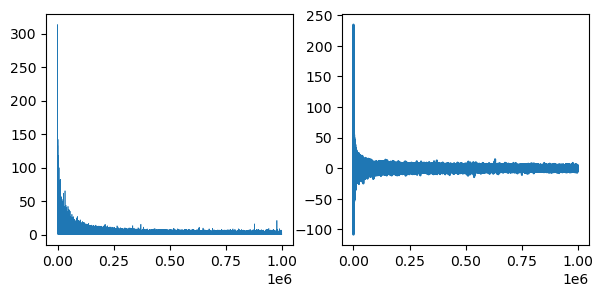

In [159]:
# create random game states and then train a network to predict current hand score...
def generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=False):
    numInHands = np.random.randint(numDominoes+1)
    idxInHands = np.random.choice(numDominoes,numInHands,replace=False)
    handIdx = np.random.randint(0, numPlayers, numInHands)
    played = np.full(numDominoes, True)
    myHand = np.full(numDominoes, False)
    otherHands = np.full(numDominoes, False)
    played[idxInHands]=False
    myHand[idxInHands[handIdx==0]] = True
    otherHands[idxInHands[handIdx>0]] = True
    myHandValue = np.sum(dominoes[myHand])
    otherHandValue = np.sum(dominoes[otherHands])
    if verboseOutput:
        return played, myHand, otherHands, myHandValue, otherHandValue
    networkInput = (np.concatenate((played, myHand))*1)
    networkOutput = np.array([myHandValue, otherHandValue])
    # networkInput = np.concatenate((np.sum(dominoes.T * played, axis=0), np.sum(dominoes.T * myHand, axis=0)))
    return networkInput, networkOutput

# played, myHand, otherHands, myHandValue, otherHandValue = generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=True)
networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)

numPlayers = 3
highestDominoe = 9
numDominoes = df.numberDominoes(highestDominoe)
dominoes = df.listDominoes(highestDominoe)

handValueNetwork = dn.handValueNetwork(numPlayers,numDominoes,highestDominoe)
handValueNetwork.to(device)

numIterations = 1000000
target = np.zeros((numIterations, 2))
pred = np.zeros((numIterations, 2))
storeLoss = np.zeros(numIterations)

lossFunction = nn.L1Loss()
# optimizer = torch.optim.SGD(handValueNetwork.parameters(), lr=1e-2, momentum=0.5)
optimizer = torch.optim.Adadelta(handValueNetwork.parameters())

for ii in tqdm(range(numIterations)):
    networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)
    target[ii] = np.copy(networkOutput)
    
    networkInput = torch.tensor(networkInput).to(device).float()
    networkOutput = torch.tensor(networkOutput).to(device).float()
    
    output = handValueNetwork(networkInput)
    
    loss = lossFunction(output, networkOutput)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    storeLoss[ii] = loss.item()
    pred[ii] = output.detach().cpu().numpy()
    
print(np.mean(storeLoss[-100:]))
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].plot(range(numIterations), storeLoss, linewidth=0.5)
ax[1].plot(range(numIterations), pred[:,0]-target[:,0])

In [ ]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
print(f"Line available: {game.available}, dummy available: {game.dummyAvailable}")
print(f"Penny-up: {game.cantPlay}, dummy playable: {game.dummyPlayable}")
print(f"Hand-size: {game.handSize}, manualHandSize: {[len(agent.myHand) for agent in game.agents]}")
print("")
game.agents[game.nextPlayer].gameState(game.played, game.available, game.handSize, game.cantPlay, game.didntPlay, game.turnCounter, game.dummyAvailable, game.dummyPlayable)
lineOptions, dummyOptions = game.agents[game.nextPlayer].playOptions()
df.printDominoeList(lineOptions, game.agents[game.nextPlayer].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[game.nextPlayer].dominoes, name='dummy:')
dominoe, location = game.agents[game.nextPlayer].selectPlay()
if dominoe is not None:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent played dominoe: {dominoe}: {df.dominoesString(game.dominoes[dominoe])} on location: {location}.")
else:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent could not play!")
game.doTurn()

In [206]:
print("hello")

hello
